In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import IPython.display as ipd
import os

In [ ]:

metadata = pd.read_csv('/home/saji/DSprojects/CloneVoiceDetection/data/ASVspoof2021_LA_eval/metadata.csv')

audio_dir = "/home/saji/DSprojects/CloneVoiceDetection/data/ASVspoof2021_LA_eval/flac/"

In [25]:
metadata.head()

,0,1,2,3,4,5,6,7
0,LA_0009,LA_E_9332881,alaw,ita_tx,A07,spoof,notrim,eval
1,LA_0009,LA_E_6866159,alaw,ita_tx,A07,spoof,notrim,eval
2,LA_0009,LA_E_5464494,alaw,sin_tx,A07,spoof,notrim,eval
3,LA_0009,LA_E_4759417,alaw,sin_tx,A07,spoof,notrim,eval
4,LA_0009,LA_E_2667748,alaw,loc_tx,A07,spoof,notrim,eval


In [26]:
metadata.columns = ["speaker_ID","audio_ID","codec","transmission_geo", "spoof_type", "target", "trim_status", "subset"]

In [27]:
#Assigning Gender of voices based on ASVspoof 2019 dataset
male = {'LA_0071','LA_0073','LA_0070','LA_0076','LA_0007','LA_0003','LA_0015','LA_0005','LA_0048','LA_0038','LA_0032','LA_0046','LA_0018','LA_0013','LA_0036','LA_0023','LA_0030','LA_0002','LA_0040','LA_0028','LA_0011','LA_0001','LA_0044','LA_0021','LA_0025'}
female = {'LA_0078','LA_0075','LA_0074','LA_0072','LA_0077','LA_0069','LA_0026','LA_0041','LA_0043','LA_0012','LA_0031','LA_0037','LA_0008','LA_0029','LA_0004','LA_0045','LA_0010','LA_0034','LA_0033','LA_0042','LA_0035','LA_0027','LA_0014','LA_0024','LA_0016','LA_0017','LA_0019','LA_0006','LA_0039','LA_0009','LA_0047','LA_0022','LA_0020'}
print(len(male), len(female))

25 33


In [28]:
metadata['gender'] = metadata['speaker_ID'].apply(lambda x: 'male' if x in male else ('female' if x in female else 'unknown'))

In [29]:
librosa.get_duration(filename='/home/saji/DSprojects/CloneVoiceDetection/data/ASVspoof2021_LA_eval/flac/'+'LA_E_7493540.flac')

/tmp/ipykernel_42025/4015277969.py:1: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.get_duration(filename='/home/saji/DSprojects/CloneVoiceDetection/data/ASVspoof2021_LA_eval/flac/'+'LA_E_7493540.flac')


5.42

In [ ]:
# Remove audios less that 1 sec in duration
indices_to_remove = []

for index, row in metadata.iterrows():
    audio_file_path = os.path.join(audio_dir, row['audio_ID'] + '.flac')

    duration = librosa.get_duration(filename=audio_file_path)

    if duration < 1.0:
        indices_to_remove.append(index)

metadata = metadata.drop(indices_to_remove)

metadata.reset_index(drop=True, inplace=True)

# metadata.to_csv("modified_metadata.csv", index=False)


In [28]:
len(indices_to_remove)

5177

In [ ]:
metadata.to_csv("/home/saji/DSprojects/CloneVoiceDetection/data/modified_metadata.csv", index=False)

In [31]:
# metadata = pd.read_csv('/home/saji/DSprojects/CloneVoiceDetection/data/modified_metadata.csv')

<Figure size 1000x600 with 0 Axes>

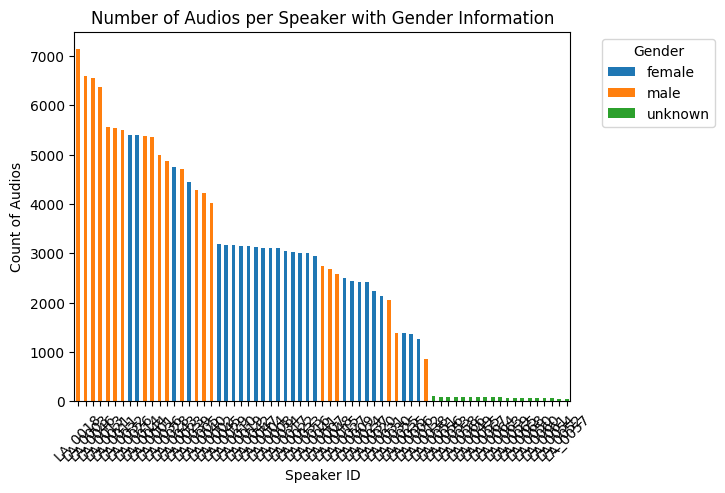

In [33]:
# Group metadata by speaker and count the number of audios per speaker
speaker_counts = metadata.groupby(['speaker_ID', 'gender']).size().unstack(fill_value=0)

speaker_counts['Total'] = speaker_counts.sum(axis=1)
speaker_counts.sort_values(by='Total', ascending=False, inplace=True)
speaker_counts.drop(columns='Total', inplace=True)

plt.figure(figsize=(10, 6))
speaker_counts.plot(kind='bar', stacked=True)
plt.title('Number of Audios per Speaker with Gender Information')
plt.xlabel('Speaker ID')
plt.ylabel('Count of Audios')
plt.xticks(rotation=45)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


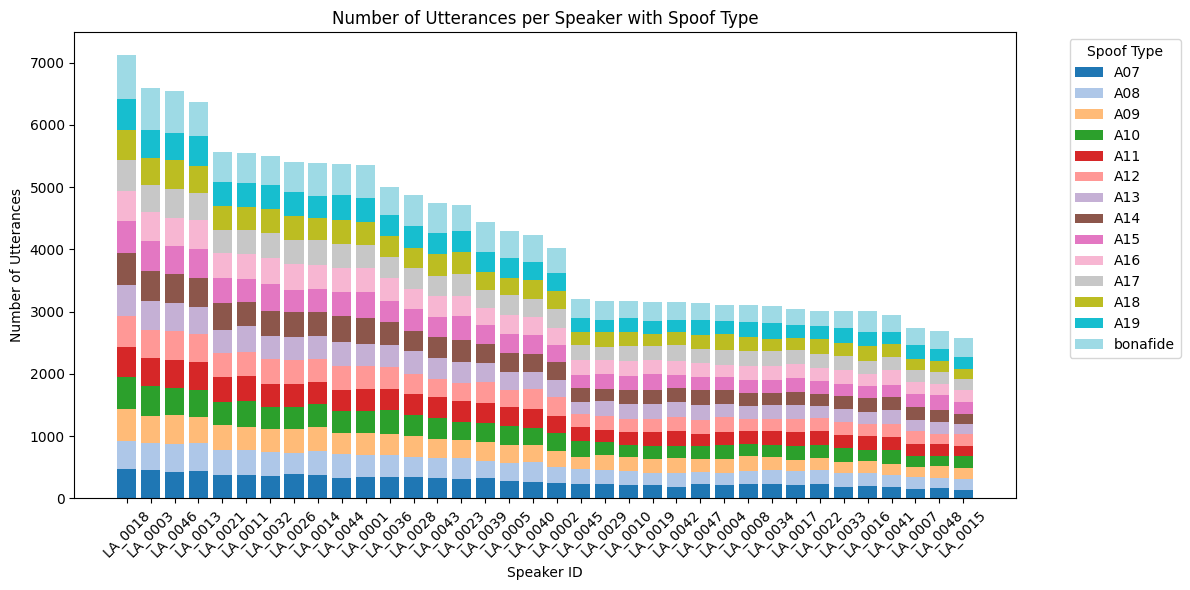

In [34]:
# Identify speakers with more than 2500 utterances
speakers_above_threshold = speaker_counts[speaker_counts.sum(axis=1) > 2500].index

filtered_metadata = metadata[metadata['speaker_ID'].isin(speakers_above_threshold)]

speaker_spoof_counts = filtered_metadata.groupby(['speaker_ID', 'spoof_type']).size().unstack(fill_value=0)

speaker_total_utterances = speaker_spoof_counts.sum(axis=1)
speaker_total_utterances_sorted = speaker_total_utterances.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
colors = plt.cm.tab20(np.linspace(0, 1, len(speaker_spoof_counts.columns)))

bottom = np.zeros(len(speaker_total_utterances_sorted))
for i, spoof_type in enumerate(speaker_spoof_counts.columns):
    plt.bar(speaker_total_utterances_sorted.index, 
            speaker_spoof_counts.loc[speaker_total_utterances_sorted.index, spoof_type], 
            bottom=bottom, 
            color=colors[i], label=spoof_type)
    bottom += speaker_spoof_counts.loc[speaker_total_utterances_sorted.index, spoof_type]

plt.title('Number of Utterances per Speaker with Spoof Type')
plt.xlabel('Speaker ID')
plt.ylabel('Number of Utterances')
plt.xticks(rotation=45)
plt.legend(title='Spoof Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [78]:
#Fix a max data points for a speaker and remove the rest
#Sample
max_data_points = 2500

speaker = 'LA_0041'
indices = metadata[(metadata['speaker_ID'] == speaker) & (metadata['target'] == 'spoof')].index
spoof_counts = metadata.loc[indices].groupby('spoof_type').size()
#num_data_points_to_remove = spoof_counts.apply(lambda x: max(0, min(x, (x - max_data_points) // len(spoof_counts))))

In [79]:
spoof_counts
#the count seems to be balances across difference spoof types as shown in the graph

spoof_type
A07    181
A08    195
A09    183
A10    223
A11    208
A12    205
A13    226
A14    203
A15    203
A16    237
A17    203
A18    213
A19    196
dtype: int64

In [81]:
# Remove equal no. of datapoints from each spoof type to retain the balanced distribution. 
num_data_points_to_remove =  spoof_counts.apply(lambda x: (spoof_counts.sum(axis=0) - max_data_points) // len(spoof_counts))

In [82]:
num_data_points_to_remove

spoof_type
A07    13
A08    13
A09    13
A10    13
A11    13
A12    13
A13    13
A14    13
A15    13
A16    13
A17    13
A18    13
A19    13
dtype: int64

In [96]:
# Define the maximum number of data points to keep per speaker
max_data_points = 1500

speakers_above_threshold = speaker_counts[speaker_counts.sum(axis=1) > max_data_points].index

indices_to_remove = []

for speaker in speakers_above_threshold:
    
    indices = metadata[(metadata['speaker_ID'] == speaker) & (metadata['target'] == 'spoof')].index

    spoof_counts = metadata.loc[indices].groupby('spoof_type').size()
    
    # Calculate the number of data points to remove from each spoof category
    num_data_points_to_remove =  spoof_counts.apply(lambda x: abs((spoof_counts.sum(axis=0) - max_data_points) // len(spoof_counts)))
    
    for spoof_type in num_data_points_to_remove.index:
        spoof_indices = metadata[(metadata['speaker_ID'] == speaker) & (metadata['spoof_type'] == spoof_type)].index
        indices_to_remove.extend(np.random.choice(spoof_indices, size=num_data_points_to_remove[spoof_type], replace=False))

filtered_metadata = metadata.drop(indices_to_remove)

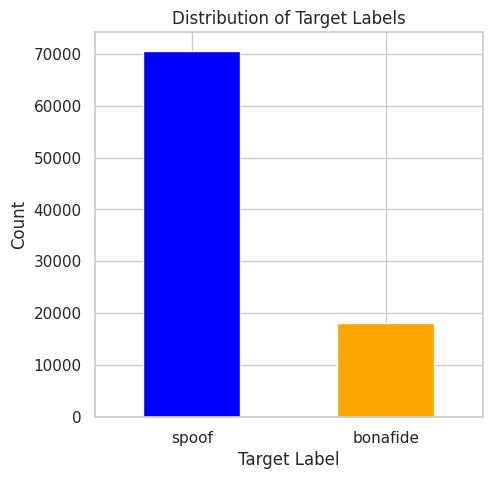

In [92]:
# the target distribution after removing the extra utterances. 
target_distribution = filtered_metadata['target'].value_counts()

plt.figure(figsize=(5, 5))
target_distribution.plot(kind='bar',color=['blue','orange'])
plt.title('Distribution of Target Labels')
plt.xlabel('Target Label')
plt.ylabel('Count')
plt.xticks(rotation=0) 
plt.show()

In [94]:
len(filtered_metadata)

88769

In [95]:
# filtered_metadata.to_csv("/home/saji/DSprojects/CloneVoiceDetection/data/modified_1500.csv", index=False)


In [35]:
data = pd.read_csv('/home/saji/DSprojects/CloneVoiceDetection/data/modified_1500.csv')

In [4]:
data.describe()

,speaker_ID,audio_ID,codec,transmission_geo,spoof_type,target,trim_status,subset,gender
count,88769,88769,88769,88769,88769,88769,88769,88769,88769
unique,67,88769,7,5,14,2,2,3,3
top,LA_0018,LA_E_9332881,gsm,loc_tx,bonafide,spoof,notrim,eval,female
freq,2214,1,12769,37601,18185,70584,81996,73793,47521


In [5]:
#copy only the required audios to a different directory
import os
import shutil

source_dir = "/home/saji/DSprojects/CloneVoiceDetection/data/ASVspoof2021_LA_eval/flac/"
destination_dir = "/home/saji/DSprojects/CloneVoiceDetection/data/reduced_LA/flac/"

os.makedirs(destination_dir, exist_ok=True)

for filename in data['audio_ID']:
    source_file = os.path.join(source_dir, filename + ".flac")
    destination_file = os.path.join(destination_dir, filename + ".flac")
    
    if os.path.exists(source_file):
        shutil.copyfile(source_file, destination_file)
    else:
        print(f"Source file {source_file} does not exist.")

print("Files copied successfully.")


Files copied successfully.
